In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from stats_utils import *
from matter import *
import seaborn as sns
import time

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

In [3]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [4]:
orders = np.array([0, 2, 3, 4])
body2 = 'NN-only'
body3 = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
valid1 = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
[fit_n2lo, fit_n3lo] = fits[Lambda]

excluded = np.array([0, 1])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None

nugget = 1e-8

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16




mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask_2bf = \
    (df['Body'] == body2) & \
    mask_fit & \
    (df['Lambda'] == Lambda)

mask_3bf = \
    (df['Body'] == body3) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n_2bf = df[mask_2bf & (df['x'] == 0)]
df_s_2bf = df[mask_2bf & (df['x'] == 0.5)]
df_n_2_plus_3bf = df[mask_3bf & (df['x'] == 0)]
df_s_2_plus_3bf = df[mask_3bf & (df['x'] == 0.5)]

kf_n = df_n_2bf[df_n_2bf['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s_2bf[df_s_2bf['OrderEFT'] == 'LO']['kf'].values
density = df_n_2bf[df_n_2bf['OrderEFT'] == 'LO']['n'].values
kf_d = kf_n.copy()

# valid1 = np.arange(len(kf_n)) % 5 != 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
Kf_n_dense = kf_n_dense[:, None]

kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
Kf_s_dense = kf_s_dense[:, None]

kf_d_dense = np.linspace(kf_d.min(), kf_d.max(), 100)
Kf_d_dense = kf_d_dense[:, None]


# ref_n_3bf = 16 * kf_n**3
# ref_s_3bf = 16 * kf_s**3
# ref_d_3bf = 16 * kf_d**3
ref_n_3bf = 8 * kf_n**6
ref_s_3bf = 8 * kf_s**6
ref_d_3bf = 8 * kf_d**6


y_n_2bf = np.array([
    df_n_2bf[df_n_2bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_n_2bf['OrderEFT'].unique()
]).T
y_s_2bf = np.array([
    df_s_2bf[df_s_2bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_s_2bf['OrderEFT'].unique()
]).T
y_d_2bf = y_n_2bf - y_s_2bf

y_n_2_plus_3bf = np.array([
    df_n_2_plus_3bf[df_n_2_plus_3bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_n_2_plus_3bf['OrderEFT'].unique()
]).T
y_s_2_plus_3bf = np.array([
    df_s_2_plus_3bf[df_s_2_plus_3bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_s_2_plus_3bf['OrderEFT'].unique()
]).T
y_d_2_plus_3bf = y_n_2_plus_3bf - y_s_2_plus_3bf


y_n_3bf = y_n_2_plus_3bf - y_n_2bf
y_s_3bf = y_s_2_plus_3bf - y_s_2bf
y_d_3bf = y_d_2_plus_3bf - y_d_2bf

In [5]:
Q_n = ratio_kf(Kf_n, breakdown=Lb)
Q_s = ratio_kf(Kf_d, breakdown=Lb)
Q_d = ratio_kf(Kf_d, breakdown=Lb)

In [6]:
coeffs_n_2_plus_3bf = gm.coefficients(y_n_2_plus_3bf, Q_n, ref_2bf, orders=orders)
coeffs_s_2_plus_3bf = gm.coefficients(y_s_2_plus_3bf, Q_s, ref_2bf, orders=orders)
coeffs_d_2_plus_3bf = gm.coefficients(y_d_2_plus_3bf, Q_d, ref_2bf, orders=orders)

coeffs_n_2bf = gm.coefficients(y_n_2bf, Q_n, ref_2bf, orders=orders)
coeffs_s_2bf = gm.coefficients(y_s_2bf, Q_s, ref_2bf, orders=orders)
coeffs_d_2bf = gm.coefficients(y_d_2bf, Q_d, ref_2bf, orders=orders)

coeffs_n_3bf = gm.coefficients(y_n_3bf, Q_n, ref_n_3bf, orders=orders)
coeffs_s_3bf = gm.coefficients(y_s_3bf, Q_s, ref_s_3bf, orders=orders)
coeffs_d_3bf = gm.coefficients(y_d_3bf, Q_d, ref_d_3bf, orders=orders)

In [7]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]

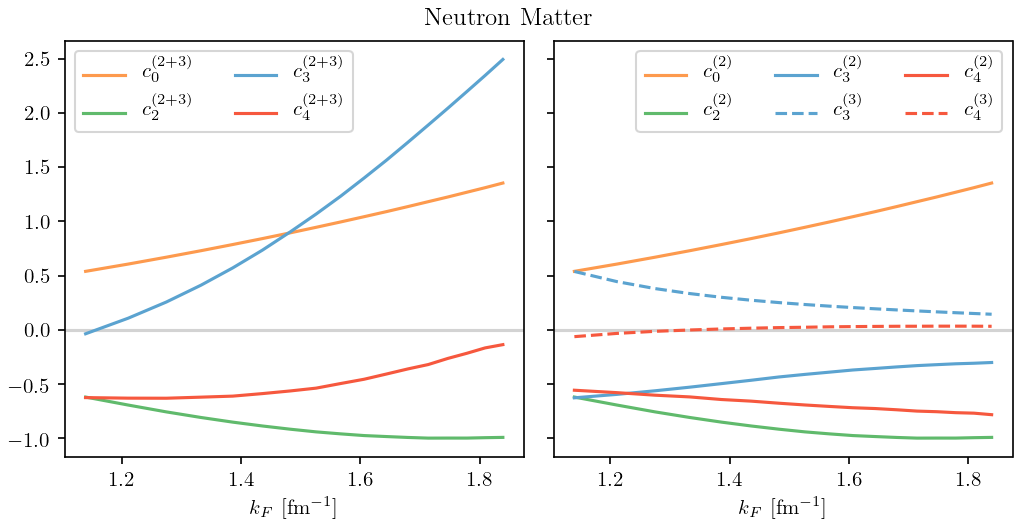

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True, sharex=True)
for i, n in enumerate(orders):
    
    axes[0].plot(kf_n, coeffs_n_2_plus_3bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
    
    axes[1].plot(kf_n, coeffs_n_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
    if n > 2:
        axes[1].plot(kf_n, coeffs_n_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, c='lightgrey', zorder=0)
    ax.set_xlabel(r'$k_F$ [fm$^{-1}$]')
axes[0].legend(ncol=2)
axes[1].legend(ncol=3)
fig.suptitle('Neutron Matter', y=1.02)
fig.tight_layout()
fig.savefig('neutron_matter_coeffs_compare_2bf_3bf')

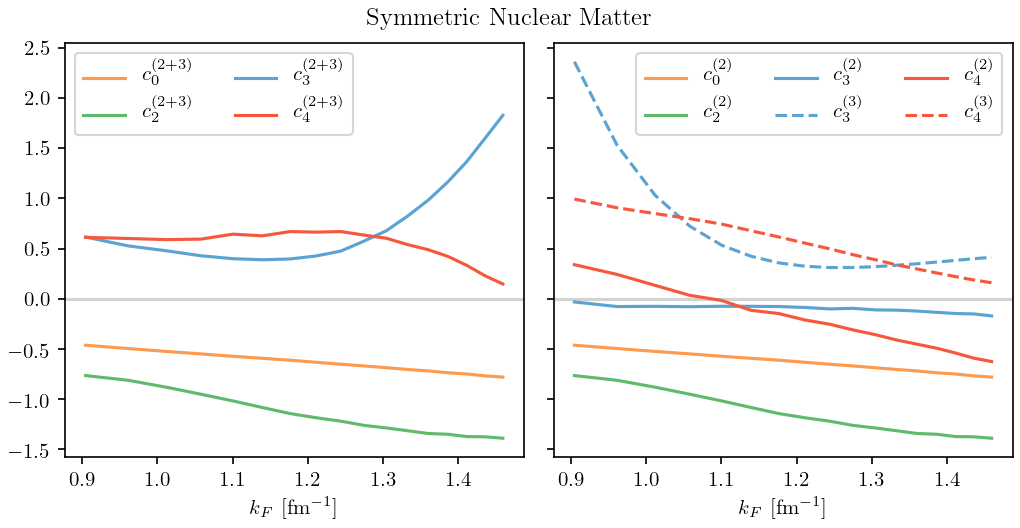

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True, sharex=True)
for i, n in enumerate(orders):
    
    axes[0].plot(kf_s, coeffs_s_2_plus_3bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
    
    axes[1].plot(kf_s, coeffs_s_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
    if n > 2:
        axes[1].plot(kf_s, coeffs_s_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, c='lightgrey', zorder=0)
    ax.set_xlabel(r'$k_F$ [fm$^{-1}$]')
axes[0].legend(ncol=2)
axes[1].legend(ncol=3)
fig.suptitle('Symmetric Nuclear Matter', y=1.02)
fig.tight_layout()
fig.savefig('nuclear_matter_coeffs_compare_2bf_3bf')

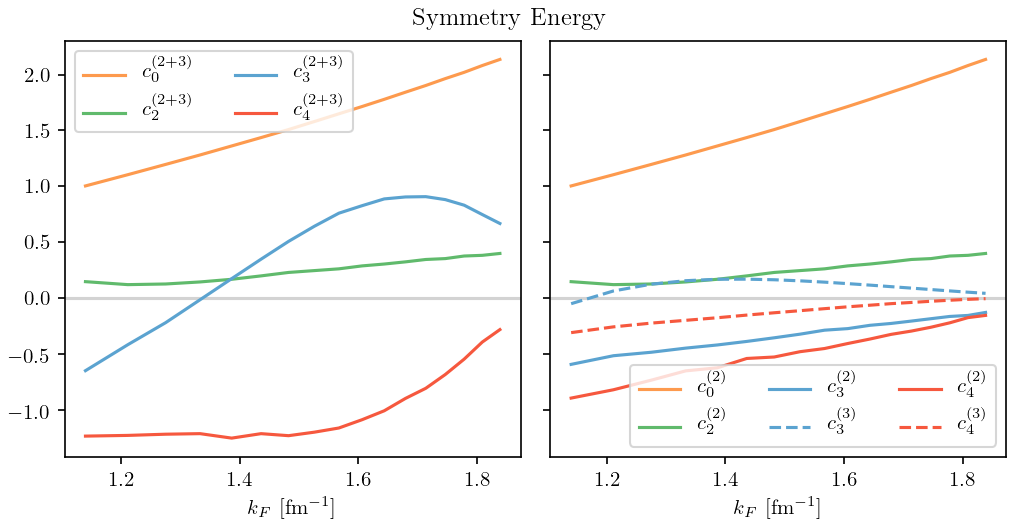

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True, sharex=True)
for i, n in enumerate(orders):
    
    axes[0].plot(kf_d, coeffs_d_2_plus_3bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
    
    axes[1].plot(kf_d, coeffs_d_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
    if n > 2:
        axes[1].plot(kf_d, coeffs_d_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, c='lightgrey', zorder=0)
    ax.set_xlabel(r'$k_F$ [fm$^{-1}$]')
axes[0].legend(ncol=2)
axes[1].legend(ncol=3)
fig.suptitle('Symmetry Energy', y=1.02)
fig.tight_layout()
fig.savefig('symmetry_energy_coeffs_compare_2bf_3bf')